Part 1 is initial attempt for wave reconstruction with 20Hz sampling, and see rough estimate of instantaneous velocity of the motor - edits last done in June

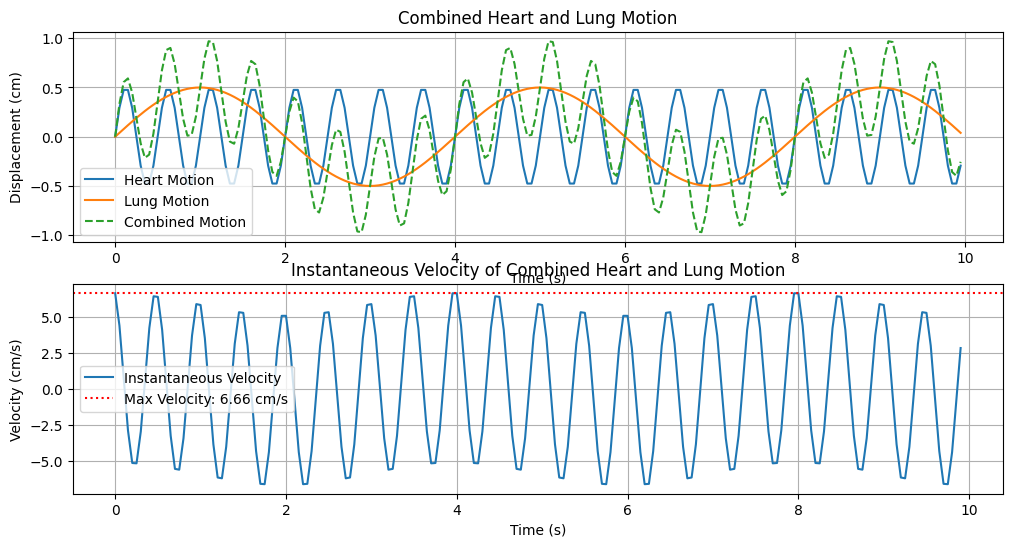

Maximum per-second travel speed required: 6.66 cm/s


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Heart parameters (2cm max peak-peak, 1cm avg)
heart_amplitude = 0.5
heart_frequency = 120 / 60

# Lung parameters (2cm max peak-peak, 1cm avg)
lung_amplitude = 0.5
lung_frequency = 15 / 60 

dt = 0.05
# Time array, 10s
t = np.arange(0, 10, dt)

# Heart and lung motion as sine waves
heart_motion = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t)
lung_motion = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t)
combined_motion = heart_motion + lung_motion

# # Motor parameters
# motor_speed_cm_per_s = 4  # Motor speed in cm/s

# Generate motor instructions
# instructions = []
# current_position = 0  # Initial position

# for i in range(1, len(t)):
#     displacement = combined_motion[i] - combined_motion[i - 1]
#     time_needed = abs(displacement) / motor_speed_cm_per_s
#     direction = '+' if displacement > 0 else '-'
#     instructions.append(f"{direction}{time_needed:.2f}s")

# for i, instruction in enumerate(instructions):
#     print(f"Time {t[i]:.1f}s: Move {instruction}")

# Visualization of motion waveforms
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, heart_motion, label='Heart Motion')
plt.plot(t, lung_motion, label='Lung Motion')
plt.plot(t, combined_motion, label='Combined Motion', linestyle='--')
plt.title('Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)

# Visualization of instantaneous velocity
velocity = np.diff(combined_motion) / dt
plt.subplot(2, 1, 2)
plt.plot(t[:-1], velocity, label='Instantaneous Velocity')
max_velocity = np.max(np.abs(velocity))
plt.axhline(max_velocity, color='r', linestyle=':', label=f'Max Velocity: {max_velocity:.2f} cm/s')
plt.title('Instantaneous Velocity of Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.grid(True)

plt.show()

print(f'Maximum per-second travel speed required: {max_velocity:.2f} cm/s')

Part 2: Determine the right sampling rate for wave reconstruction, comparisons, 8Hz seemed pretty reasonable for a first test, later on can add greater accuracy with finer resol

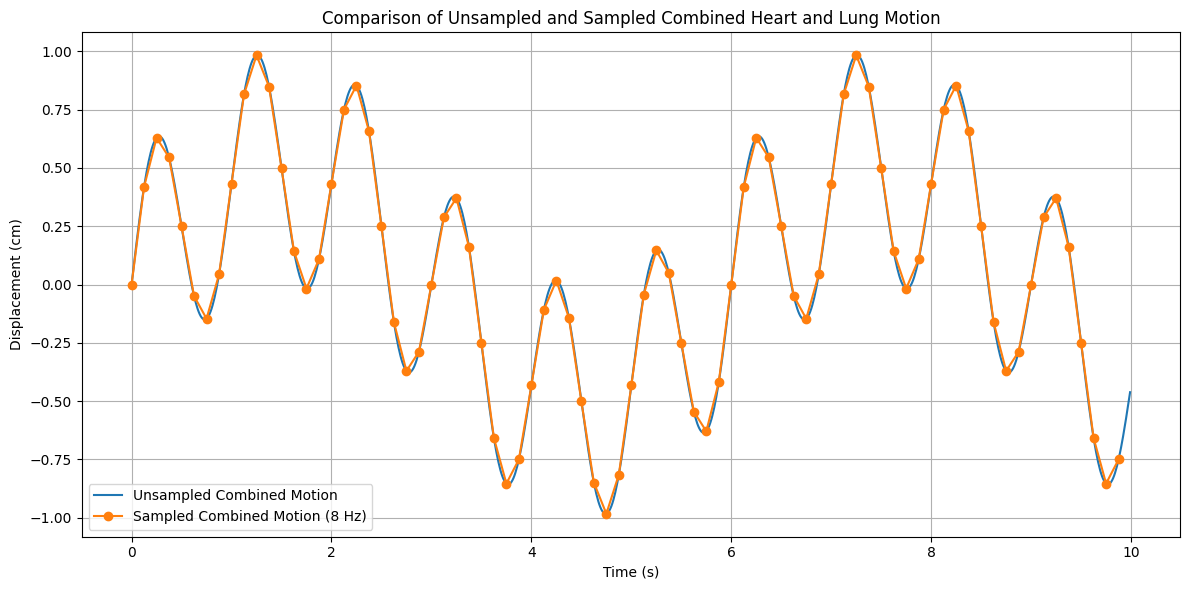

Maximum travel distance between consecutive sampling points: 0.4188164867032996 cm
Speed required: 3.3505318936263966 cm


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Heart parameters (2cm max peak-peak, 1cm avg)
heart_amplitude = 0.5
heart_frequency = 60 / 60

# Lung parameters (2cm max peak-peak, 1cm avg)
lung_amplitude = 0.5
lung_frequency = 10 / 60 

# Time array with finer resolution, 10s
t_fine = np.arange(0, 10, 0.01)

# Unsampled - finer time resolution
heart_motion_fine = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t_fine)
lung_motion_fine = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t_fine)
combined_motion_fine = heart_motion_fine + lung_motion_fine

# Sampling
sampling_rate = 8 
sampling_interval = 1 / sampling_rate
t_sampled = np.arange(0, 10, sampling_interval)
heart_motion_sampled = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t_sampled)
lung_motion_sampled = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t_sampled)
combined_motion_sampled = heart_motion_sampled + lung_motion_sampled

# Calculate maximum travel distance between consecutive sampling points
travel_distances = np.abs(np.diff(combined_motion_sampled))  # Calculate differences between consecutive points
max_travel_distance = np.max(travel_distances)  # Find the maximum travel distance

# Plotting
plt.figure(figsize=(12, 6))

# Plot unsampled and sampled combined motion
plt.plot(t_fine, combined_motion_fine, label='Unsampled Combined Motion', linestyle='-')
plt.plot(t_sampled, combined_motion_sampled, 'o-', label='Sampled Combined Motion (8 Hz)')
plt.title('Comparison of Unsampled and Sampled Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the maximum travel distance between consecutive sampling points
print(f'Maximum travel distance between consecutive sampling points: {max_travel_distance} cm')
print(f'Speed required: {max_travel_distance/sampling_interval} cm')

# Lead screw parameters
lead = 0.8
rpm = 200



Part 3: Sending start command (two parts to this)
- Once the user pressed the start button, python will sample the wave, calculate the number of steps in between each interval, and flush the array of step commands to arduino ([10,-20,30] etc.) in a single message (similar to a program button)
- and then the arduino is going to iterate through the command for each given time step dt (that is used to sample) until the user sends an "X" message to the arduino

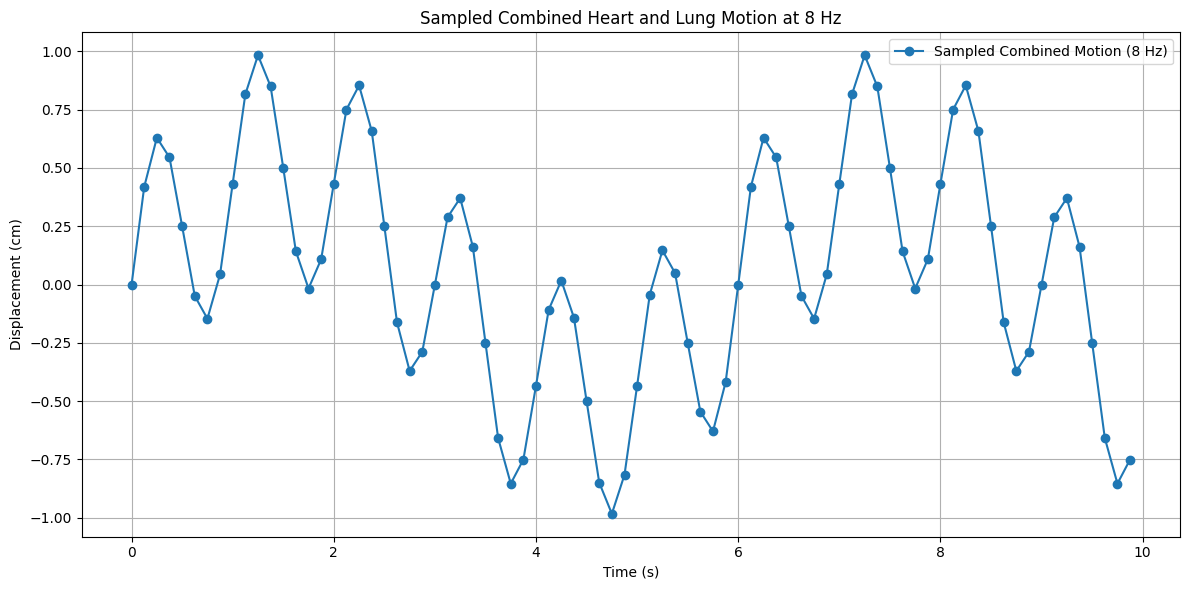

Max step: 104.16666666666667
Motor Instructions (steps per 0.125s): 0,105,157,136,63,-12,-37,11,108,204,246,212,125,36,-4,27,108,188,213,164,63,-41,-93,-72,0,72,93,41,-62,-164,-213,-188,-108,-27,4,-36,-125,-212,-246,-204,-108,-11,37,12,-62,-136,-157,-105,0,105,157,136,62,-12,-37,11,108,204,246,212,125,36,-4,27,108,188,213,164,62,-41,-93,-72,0,72,93,41,-62,-164,-213,-188


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Heart parameters (2cm max peak-peak, 1cm avg)
heart_amplitude = 0.5
heart_frequency = 120 / 60

# Lung parameters (2cm max peak-peak, 1cm avg)
lung_amplitude = 0.5
lung_frequency = 15 / 60 

# Sampling
sampling_rate = 8 
sampling_interval = 1 / sampling_rate
t_sampled = np.arange(0, 10, sampling_interval)
heart_motion_sampled = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t_sampled)
lung_motion_sampled = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t_sampled)
combined_motion_sampled = heart_motion_sampled + lung_motion_sampled

# Motor parameters
motor_speed_rpm = 250  # Motor speed in RPM
lead_screw_lead = 8  # Lead of thread in mm (travel per revolution)
steps_per_revolution = 200  # Steps per revolution for the stepper motor

# Calculate the displacement in mm (combined motion in cm to mm)
combined_motion_sampled_mm = combined_motion_sampled * 10  # Convert cm to mm

# Calculate the number of steps required for each displacement
steps_per_mm = steps_per_revolution / lead_screw_lead  # Steps per mm
motor_steps = np.round(combined_motion_sampled_mm * steps_per_mm).astype(int)

# Prepare motor instructions as a single message
motor_instructions = ','.join(map(str, motor_steps))

# Plotting for visualization
plt.figure(figsize=(12, 6))
plt.plot(t_sampled, combined_motion_sampled, 'o-', label='Sampled Combined Motion (8 Hz)')
plt.title('Sampled Combined Heart and Lung Motion at 8 Hz')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print motor instructions
print(f'Max step: {sampling_interval*steps_per_revolution*motor_speed_rpm/60}')
print(f'Motor Instructions (steps per 0.125s): {motor_instructions}')
